# Setup Fiducial Cosmology

Import relevant python packages... 

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt

sns.set()

Import the analysis package.

In [2]:
import cosmicfish as cf 

Specify the values of your fiducial cosmology and other physical constants.

In [3]:
fid = {"A_s" : 2.2321e-9, 
        "n_s" : 0.96659,
        "omega_b" : 0.02226,
        "omega_cdm" : 0.11271,
        "tau_reio" : 0.059888,
        "h" : 0.70148,
        "z_pk" : 0.7} #Not necessary, but helps neatness later on

A_s = 2.2321e-9
n_s = 0.96659
omega_b = 0.02226
omega_cdm = 0.11271
tau_reio = 0.059888
h = 0.70148
z_pk = 0.7

c = 2.9979e8 #Units of m/s
H = 1000. * 100. * fid['h'] #Units of m/s/Mpc
kp = 0.05 * fid['h'] #Units of 1/Mpc
t_cmb = 2.726


# Calculate Power Spectra

Specify points of interest to accumulate power spectra at... 

In [4]:
z_table = np.arange(0.7, 2.1, 0.1)
m_chi_table = np.logspace(-1.0, 1.0, num=21, endpoint=True)

Determine derived quantities... Here, we assume the following relations: 

$$ \omega_\chi = \Big(\frac{T_\chi}{1.95 \textrm{[K]} }\Big)^3 \Big( \frac{m_\chi}{94 \textrm{[eV]}}\Big) $$

$$ \omega_m = \omega_b + \omega_{cdm} + \omega_\chi $$

$$ \omega_\lambda = h^2 - \omega_m$$

$$ V_{eff} = \Big(\frac{4 \pi}{3}\Big)\Big(\frac{c}{H}\Big)^3\Big( \int_{0.7}^{2.0} \frac{h}{\sqrt{\omega_m (1+z)^3 + \omega_\lambda}}  ~dz\Big)^3 $$

In [5]:
T_chi = 0.5 #CAUTION! USING A SINGLE T VALUE TO CALCULATE THIS BLOCK!
omega_chi_table = np.power((T_chi / 1.95), 3.) * (m_chi_table / 94.)
omega_m_table = fid["omega_b"] + fid["omega_cdm"] + omega_chi_table
omega_lambda_table = np.power(h, 2.) - omega_m_table
v_eff_table = cf.v_effective_table_generator(z_table, omega_m_table, omega_lambda_table, c, h, H)
k_table = cf.k_table_generator(v_eff_table, h, 0.1, 100) 
prim_table = cf.primordial_table_generator(k_table, A_s, n_s, kp)

At this point, we have $\omega_m$, $\omega_{\lambda}$, $\omega_{\chi}$, $V_{eff}$ for several values of $m_\chi$ assuming a particular value of $T_\chi$. For transparency, let's show what these all look like... 

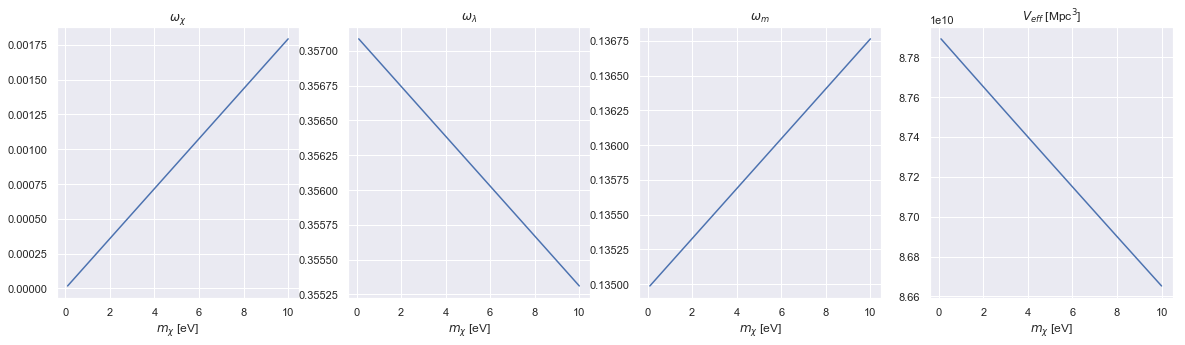

In [6]:
fig, ax = plt.subplots(1,4, figsize=(20, 5))
ax[0].plot(m_chi_table, omega_chi_table)
ax[0].set_title(r'$\omega_\chi$')
ax[0].set_xlabel(r'$m_\chi$ [eV]')
ax[1].plot(m_chi_table, omega_lambda_table, label=r'$\omega_\lambda$')
ax[1].set_title(r'$\omega_\lambda$')
ax[1].set_xlabel(r'$m_\chi$ [eV]')
ax[2].plot(m_chi_table, omega_m_table, label=r'$\omega_m$')
ax[2].set_title(r'$\omega_m$')
ax[2].set_xlabel(r'$m_\chi$ [eV]')
ax[3].plot(m_chi_table, v_eff_table)
ax[3].set_title(r'$V_{eff}$ [Mpc$^3$]')
ax[3].set_xlabel(r'$m_\chi$ [eV]')
plt.show()

These all behave in an obvious way. Notice also that our k_table, which spans 100 points at each choice of $m_\chi$, has the first few values of k given by: 

In [7]:
pd.DataFrame(k_table).head()

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
0,0.001007,0.001007,0.001007,0.001007,0.001007,0.001007,0.001007,0.001007,0.001008,0.001008,...,0.001008,0.001008,0.001008,0.001008,0.001009,0.001009,0.001010,0.00101,0.001011,0.001012
1,0.002007,0.002007,0.002007,0.002007,0.002007,0.002007,0.002007,0.002007,0.002007,0.002008,...,0.002008,0.002008,0.002008,0.002008,0.002009,0.002009,0.002010,0.00201,0.002011,0.002012
2,0.003007,0.003007,0.003007,0.003007,0.003007,0.003007,0.003007,0.003007,0.003007,0.003007,...,0.003008,0.003008,0.003008,0.003008,0.003009,0.003009,0.003009,0.00301,0.003011,0.003012
3,0.004007,0.004007,0.004007,0.004007,0.004007,0.004007,0.004007,0.004007,0.004007,0.004007,...,0.004008,0.004008,0.004008,0.004008,0.004008,0.004009,0.004009,0.00401,0.004011,0.004012
4,0.005007,0.005007,0.005007,0.005007,0.005007,0.005007,0.005007,0.005007,0.005007,0.005007,...,0.005008,0.005008,0.005008,0.005008,0.005008,0.005009,0.005009,0.00501,0.005011,0.005012


Define path where all data runs are stored. Anytime we require spectrum data from CLASS, the code will first check whether such data has already been calculated. If so, it will just import that data rather than re-run CLASS. We also specify a path to the CLASS install directory. 

In [8]:
projectdir = cf.correct_path("~/Desktop/test/")
datastore = os.path.join(projectdir, "data")
classpath = os.path.join(projectdir, "class")

If you need to install CLASS, you can do so using the built-in function:

In [9]:
#cf.install_class(projectdir)

At this point, we can quickly generate datasets of interest and plot results. For instance, consider a 1 eV relic with $T = 0.1, 0.2, 0.3, 0.4, 0.5$ [K]... 

In [10]:
gen = []
spectra = []
for i in range(6): 
    sample = dict(fid)
    sample["m_ncdm"] = 1.0
    sample["N_ncdm"] = 1
    sample["T_ncdm"] = (i+1) * 0.1
    gen.append(sample)
    del sample
for samp in gen: 
    p = cf.generate_data(fid, classpath, datastore, **samp)
    spectra = np.append(spectra, cf.spectrum(p.replace('/test_parameters.ini','')))
for el in spectra: 
    el.interpolate(k_table[:,10]/h)
    el.generate_power_spectrum(omega_b, omega_cdm, k_table[:,10], prim_table[:,10])

Dataset already exists at: /Users/nicholasdeporzio/Desktop/test/data/1558600342.86208420.006216
Dataset already exists at: /Users/nicholasdeporzio/Desktop/test/data/1558600343.21773390.946233
Dataset already exists at: /Users/nicholasdeporzio/Desktop/test/data/1558600343.56147310.284201
Dataset already exists at: /Users/nicholasdeporzio/Desktop/test/data/1558600343.948010.657064
Dataset already exists at: /Users/nicholasdeporzio/Desktop/test/data/1558600344.30662510.607268
Dataset already exists at: /Users/nicholasdeporzio/Desktop/test/data/1558600344.7104940.692067


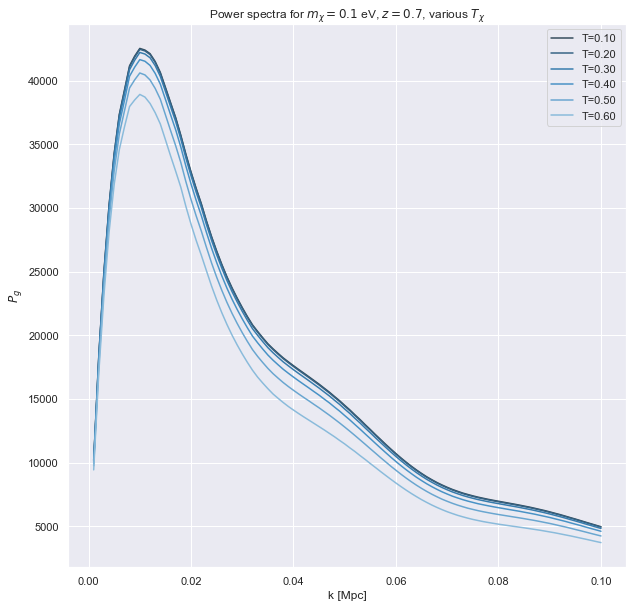

In [11]:
sns.set_palette("Blues_d", n_colors=len(spectra))
plt.figure(figsize=(10, 10))
for el in spectra: 
    plt.plot(k_table[:, 10], el.ps_table, label="T={0:.2f}".format(el.T_ncdm))
plt.xlabel("k [Mpc]")
plt.ylabel(r'$P_g$')
plt.title(r'Power spectra for $m_\chi=0.1$ eV, $z=0.7$, various $T_\chi$')
plt.legend()
plt.show()

# Convergence Tests


Working only the choice of $m_\chi = 0.1$ [eV], we wish to demonstrate convergence in some choice with which to vary the cosmological parameters of our model. To do so, we only need to specify our redshift binning and the variation on each parameter we would like to test. We repeat lines above for clarity. 

### Setup

In [12]:
A_s = 2.2321e-9
n_s = 0.96659
omega_b = 0.02226
omega_cdm = 0.11271
tau_reio = 0.059888
h = 0.70148
z_pk = 0.7

c = 2.9979e8 #Units of m/s
H = 1000. * 100. * h #Units of m/s/Mpc
kp = 0.05 * h #Units of 1/Mpc
t_cmb = 2.726

z_table = np.arange(0.7, 2.1, 0.1)
m_chi_table = np.array([1.0])

T_chi = 0.5 #Vary our relic temperature to 0.5 K 
omega_chi_table = np.power((T_chi / 1.95), 3.) * (m_chi_table / 94.)
omega_m_table = fid["omega_b"] + fid["omega_cdm"] + omega_chi_table
omega_lambda_table = np.power(h, 2.) - omega_m_table
v_eff_table = cf.v_effective_table_generator(z_table, omega_m_table, omega_lambda_table, c, h, H)
k_table = cf.k_table_generator(v_eff_table, h, 0.1, 100) 
prim_table = cf.primordial_table_generator(k_table, A_s, n_s, kp)

### Run Convergence Analysis

In [13]:
relvary = np.arange(1.01, 1.11, 0.01)
t_vary = np.arange(0.1, 2.1, 0.1)

a1 = cf.analysis('a1', z_table, k_table[:,0], classpath, datastore)
a1.generate_fiducials()
a1.generate_non_fiducials(absvary_h=relvary*h,
                     absvary_omega_b=relvary*omega_b,
                     absvary_omega_cdm=relvary*omega_cdm,
                     absvary_tau_reio=relvary*tau_reio,
                     absvary_T_ncdm=t_vary)

Dataset already exists at: /Users/nicholasdeporzio/Desktop/test/data/1558616864.3872970.330591
Dataset already exists at: /Users/nicholasdeporzio/Desktop/test/data/1558611587.7996950.668997
Dataset already exists at: /Users/nicholasdeporzio/Desktop/test/data/1558616852.32446480.138881
Dataset already exists at: /Users/nicholasdeporzio/Desktop/test/data/1558616850.0898640.182383
Dataset already exists at: /Users/nicholasdeporzio/Desktop/test/data/1558616863.5092720.598317
Dataset already exists at: /Users/nicholasdeporzio/Desktop/test/data/1558616860.4106830.802054
Dataset already exists at: /Users/nicholasdeporzio/Desktop/test/data/1558616856.3855240.657383
Dataset already exists at: /Users/nicholasdeporzio/Desktop/test/data/1558616848.6573970.596844
Dataset already exists at: /Users/nicholasdeporzio/Desktop/test/data/1558611587.1151990.358602
Dataset already exists at: /Users/nicholasdeporzio/Desktop/test/data/1558616854.3639250.713217
Dataset already exists at: /Users/nicholasdeporzi

Dataset already exists at: /Users/nicholasdeporzio/Desktop/test/data/1558616877.6372910.135226
Dataset already exists at: /Users/nicholasdeporzio/Desktop/test/data/1558616884.84399490.951047
Dataset already exists at: /Users/nicholasdeporzio/Desktop/test/data/1558616879.60735420.072317
Dataset already exists at: /Users/nicholasdeporzio/Desktop/test/data/1558609772.7774830.412204
Dataset already exists at: /Users/nicholasdeporzio/Desktop/test/data/1558616883.984740.031273
Dataset already exists at: /Users/nicholasdeporzio/Desktop/test/data/1558611593.8779910.225716
Dataset already exists at: /Users/nicholasdeporzio/Desktop/test/data/1558616885.8332720.996028
Dataset already exists at: /Users/nicholasdeporzio/Desktop/test/data/1558616882.38418980.772798
Dataset already exists at: /Users/nicholasdeporzio/Desktop/test/data/1558616891.16029210.328205
Dataset already exists at: /Users/nicholasdeporzio/Desktop/test/data/1558616890.3599520.583243
Dataset already exists at: /Users/nicholasdepor

Dataset already exists at: /Users/nicholasdeporzio/Desktop/test/data/1558616946.7920280.164995
Dataset already exists at: /Users/nicholasdeporzio/Desktop/test/data/1558609779.544190.629066
Dataset already exists at: /Users/nicholasdeporzio/Desktop/test/data/1558616949.0151790.049915
Dataset already exists at: /Users/nicholasdeporzio/Desktop/test/data/1558616943.9560850.467922
Dataset already exists at: /Users/nicholasdeporzio/Desktop/test/data/1558616939.0904870.866189
Dataset already exists at: /Users/nicholasdeporzio/Desktop/test/data/1558616948.2508940.699149
Dataset already exists at: /Users/nicholasdeporzio/Desktop/test/data/1558609778.90153810.855082
Dataset already exists at: /Users/nicholasdeporzio/Desktop/test/data/1558616943.2668770.244602
Dataset already exists at: /Users/nicholasdeporzio/Desktop/test/data/1558616933.9781360.408775
Dataset already exists at: /Users/nicholasdeporzio/Desktop/test/data/1558616931.90872810.501559
Dataset already exists at: /Users/nicholasdeporzi

Dataset already exists at: /Users/nicholasdeporzio/Desktop/test/data/1558616970.332870.190568
Dataset already exists at: /Users/nicholasdeporzio/Desktop/test/data/1558616972.64279820.444918
Dataset already exists at: /Users/nicholasdeporzio/Desktop/test/data/1558616973.39440680.222243
Dataset already exists at: /Users/nicholasdeporzio/Desktop/test/data/1558616967.27336290.318148
Dataset already exists at: /Users/nicholasdeporzio/Desktop/test/data/1558611618.127160.100831
Dataset already exists at: /Users/nicholasdeporzio/Desktop/test/data/1558609782.49844720.933381
Dataset already exists at: /Users/nicholasdeporzio/Desktop/test/data/1558611623.2347640.502051
Dataset already exists at: /Users/nicholasdeporzio/Desktop/test/data/1558616976.1352280.508236
Dataset already exists at: /Users/nicholasdeporzio/Desktop/test/data/1558616979.673540.951712
Dataset already exists at: /Users/nicholasdeporzio/Desktop/test/data/1558611621.88231090.252473
Dataset already exists at: /Users/nicholasdeporz

Dataset already exists at: /Users/nicholasdeporzio/Desktop/test/data/1558616581.5386560.207599
Dataset already exists at: /Users/nicholasdeporzio/Desktop/test/data/1558616586.6816180.406833
Dataset already exists at: /Users/nicholasdeporzio/Desktop/test/data/1558616587.5780820.344079
Dataset already exists at: /Users/nicholasdeporzio/Desktop/test/data/1558616582.3064020.562145
Dataset already exists at: /Users/nicholasdeporzio/Desktop/test/data/1558616583.1196580.230258
Dataset already exists at: /Users/nicholasdeporzio/Desktop/test/data/1558616588.4569540.995046
Dataset already exists at: /Users/nicholasdeporzio/Desktop/test/data/1558616589.3914930.881070
Dataset already exists at: /Users/nicholasdeporzio/Desktop/test/data/1558616583.8952590.844548
Dataset already exists at: /Users/nicholasdeporzio/Desktop/test/data/1558616590.31051280.517174
Dataset already exists at: /Users/nicholasdeporzio/Desktop/test/data/1558616584.67460.159633
Dataset already exists at: /Users/nicholasdeporzio/

Dataset already exists at: /Users/nicholasdeporzio/Desktop/test/data/1558616618.17055490.299922
Dataset already exists at: /Users/nicholasdeporzio/Desktop/test/data/1558616614.4922640.782296
Dataset already exists at: /Users/nicholasdeporzio/Desktop/test/data/1558616618.8361330.067491
Dataset already exists at: /Users/nicholasdeporzio/Desktop/test/data/1558616619.5456860.567662
Dataset already exists at: /Users/nicholasdeporzio/Desktop/test/data/1558616615.14695290.198347
Dataset already exists at: /Users/nicholasdeporzio/Desktop/test/data/1558616615.7983880.359538
Dataset already exists at: /Users/nicholasdeporzio/Desktop/test/data/1558616620.3186750.218076
Dataset already exists at: /Users/nicholasdeporzio/Desktop/test/data/1558616616.4582310.771296
Dataset already exists at: /Users/nicholasdeporzio/Desktop/test/data/1558616621.0608650.437404
Dataset already exists at: /Users/nicholasdeporzio/Desktop/test/data/1558616617.1296630.524440
Dataset already exists at: /Users/nicholasdeporz

Dataset already exists at: /Users/nicholasdeporzio/Desktop/test/data/1558616645.11867120.083800
Dataset already exists at: /Users/nicholasdeporzio/Desktop/test/data/1558616649.3277490.429267
Dataset already exists at: /Users/nicholasdeporzio/Desktop/test/data/1558616645.7448960.168410
Dataset already exists at: /Users/nicholasdeporzio/Desktop/test/data/1558616649.9504650.893703
Dataset already exists at: /Users/nicholasdeporzio/Desktop/test/data/1558616650.5954550.644493
Dataset already exists at: /Users/nicholasdeporzio/Desktop/test/data/1558616646.3750570.476515
Dataset already exists at: /Users/nicholasdeporzio/Desktop/test/data/1558616647.0090860.725710
Dataset already exists at: /Users/nicholasdeporzio/Desktop/test/data/1558616651.21412090.766994
Dataset already exists at: /Users/nicholasdeporzio/Desktop/test/data/1558611471.8012730.707393
Dataset already exists at: /Users/nicholasdeporzio/Desktop/test/data/1558611472.3721150.080127
Dataset already exists at: /Users/nicholasdeporz

Dataset already exists at: /Users/nicholasdeporzio/Desktop/test/data/1558616681.3648150.273304
Dataset already exists at: /Users/nicholasdeporzio/Desktop/test/data/1558616676.3608120.676655
Dataset already exists at: /Users/nicholasdeporzio/Desktop/test/data/1558616677.0547310.454371
Dataset already exists at: /Users/nicholasdeporzio/Desktop/test/data/1558616682.105610.491079
Dataset already exists at: /Users/nicholasdeporzio/Desktop/test/data/1558616677.7958740.129431
Dataset already exists at: /Users/nicholasdeporzio/Desktop/test/data/1558616682.88640520.459824
Dataset already exists at: /Users/nicholasdeporzio/Desktop/test/data/1558611490.0267560.884317
Dataset already exists at: /Users/nicholasdeporzio/Desktop/test/data/1558611490.7024230.210684
Dataset already exists at: /Users/nicholasdeporzio/Desktop/test/data/1558611491.3886020.527622
Dataset already exists at: /Users/nicholasdeporzio/Desktop/test/data/1558611492.06106110.417986
Dataset already exists at: /Users/nicholasdeporzi

Dataset already exists at: /Users/nicholasdeporzio/Desktop/test/data/1558616710.98420720.141687
Dataset already exists at: /Users/nicholasdeporzio/Desktop/test/data/1558616717.5429240.795521
Dataset already exists at: /Users/nicholasdeporzio/Desktop/test/data/1558616711.924360.408548
Dataset already exists at: /Users/nicholasdeporzio/Desktop/test/data/1558616712.79208180.413862
Dataset already exists at: /Users/nicholasdeporzio/Desktop/test/data/1558616718.2446480.861780
Dataset already exists at: /Users/nicholasdeporzio/Desktop/test/data/1558611511.2366730.166102
Dataset already exists at: /Users/nicholasdeporzio/Desktop/test/data/1558611511.9282110.178142
Dataset already exists at: /Users/nicholasdeporzio/Desktop/test/data/1558611512.7089960.045729
Dataset already exists at: /Users/nicholasdeporzio/Desktop/test/data/1558611513.5440820.751602
Dataset already exists at: /Users/nicholasdeporzio/Desktop/test/data/1558609730.4022210.762338
Dataset already exists at: /Users/nicholasdeporzi

Dataset already exists at: /Users/nicholasdeporzio/Desktop/test/data/1558616749.75950380.413409
Dataset already exists at: /Users/nicholasdeporzio/Desktop/test/data/1558616754.5696580.737380
Dataset already exists at: /Users/nicholasdeporzio/Desktop/test/data/1558616755.24283390.510096
Dataset already exists at: /Users/nicholasdeporzio/Desktop/test/data/1558616750.5551160.852501
Dataset already exists at: /Users/nicholasdeporzio/Desktop/test/data/1558616751.2294180.955351
Dataset already exists at: /Users/nicholasdeporzio/Desktop/test/data/1558616755.8916450.691408
Dataset already exists at: /Users/nicholasdeporzio/Desktop/test/data/1558611534.30324720.729602
Dataset already exists at: /Users/nicholasdeporzio/Desktop/test/data/1558611534.95375010.225871
Dataset already exists at: /Users/nicholasdeporzio/Desktop/test/data/1558611535.6009170.140313
Dataset already exists at: /Users/nicholasdeporzio/Desktop/test/data/1558611536.2391630.498625
Dataset already exists at: /Users/nicholasdepo

Dataset already exists at: /Users/nicholasdeporzio/Desktop/test/data/1558616786.1741330.686494
Dataset already exists at: /Users/nicholasdeporzio/Desktop/test/data/1558616781.6896150.540833
Dataset already exists at: /Users/nicholasdeporzio/Desktop/test/data/1558616782.3310940.550797
Dataset already exists at: /Users/nicholasdeporzio/Desktop/test/data/1558616786.8479060.875326
Dataset already exists at: /Users/nicholasdeporzio/Desktop/test/data/1558611552.4242160.438044
Dataset already exists at: /Users/nicholasdeporzio/Desktop/test/data/1558611553.01926920.522202
Dataset already exists at: /Users/nicholasdeporzio/Desktop/test/data/1558611553.6953480.800078
Dataset already exists at: /Users/nicholasdeporzio/Desktop/test/data/1558611554.28421880.586676
Dataset already exists at: /Users/nicholasdeporzio/Desktop/test/data/1558609751.55281520.084305
Dataset already exists at: /Users/nicholasdeporzio/Desktop/test/data/1558616783.5055850.459089
Dataset already exists at: /Users/nicholasdepor

Dataset already exists at: /Users/nicholasdeporzio/Desktop/test/data/1558616818.56519820.414468
Dataset already exists at: /Users/nicholasdeporzio/Desktop/test/data/1558616813.8631620.512644
Dataset already exists at: /Users/nicholasdeporzio/Desktop/test/data/1558616814.54938910.809090
Dataset already exists at: /Users/nicholasdeporzio/Desktop/test/data/1558616819.2422490.745742
Dataset already exists at: /Users/nicholasdeporzio/Desktop/test/data/1558611569.5272880.506036
Dataset already exists at: /Users/nicholasdeporzio/Desktop/test/data/1558611570.104960.259906
Dataset already exists at: /Users/nicholasdeporzio/Desktop/test/data/1558611570.6985630.762548
Dataset already exists at: /Users/nicholasdeporzio/Desktop/test/data/1558611571.3201420.989740
Dataset already exists at: /Users/nicholasdeporzio/Desktop/test/data/1558609761.7241710.033021
Dataset already exists at: /Users/nicholasdeporzio/Desktop/test/data/1558616815.7747060.791308
Dataset already exists at: /Users/nicholasdeporzi

Dataset already exists at: /Users/nicholasdeporzio/Desktop/test/data/1558616857.07354280.428778
Dataset already exists at: /Users/nicholasdeporzio/Desktop/test/data/1558616845.874020.879422
Dataset already exists at: /Users/nicholasdeporzio/Desktop/test/data/1558616857.7957070.181096
Dataset already exists at: /Users/nicholasdeporzio/Desktop/test/data/1558616846.5535790.073263
Dataset already exists at: /Users/nicholasdeporzio/Desktop/test/data/1558616858.59737180.519356
Dataset already exists at: /Users/nicholasdeporzio/Desktop/test/data/1558616847.2484190.793753
Dataset already exists at: /Users/nicholasdeporzio/Desktop/test/data/1558616847.9440530.236158
Dataset already exists at: /Users/nicholasdeporzio/Desktop/test/data/1558616859.5323190.853751
Dataset already exists at: /Users/nicholasdeporzio/Desktop/test/data/1558616860.4106830.802054
Dataset already exists at: /Users/nicholasdeporzio/Desktop/test/data/1558616848.6573970.596844
Dataset already exists at: /Users/nicholasdeporzi

Dataset already exists at: /Users/nicholasdeporzio/Desktop/test/data/1558616896.2585330.456721
Dataset already exists at: /Users/nicholasdeporzio/Desktop/test/data/1558616896.9526440.351341
Dataset already exists at: /Users/nicholasdeporzio/Desktop/test/data/1558616897.6344820.811505
Dataset already exists at: /Users/nicholasdeporzio/Desktop/test/data/1558616898.4786290.419463
Dataset already exists at: /Users/nicholasdeporzio/Desktop/test/data/1558616899.3149280.344744
Dataset already exists at: /Users/nicholasdeporzio/Desktop/test/data/1558616900.0441070.030207
Dataset already exists at: /Users/nicholasdeporzio/Desktop/test/data/1558616900.82581880.448473
Dataset already exists at: /Users/nicholasdeporzio/Desktop/test/data/1558616901.58411120.276818
Dataset already exists at: /Users/nicholasdeporzio/Desktop/test/data/1558616902.3408910.068059
Dataset already exists at: /Users/nicholasdeporzio/Desktop/test/data/1558616903.091690.303827
Dataset already exists at: /Users/nicholasdeporzi

Dataset already exists at: /Users/nicholasdeporzio/Desktop/test/data/1558616938.3598590.100793
Dataset already exists at: /Users/nicholasdeporzio/Desktop/test/data/1558616949.7551150.994755
Dataset already exists at: /Users/nicholasdeporzio/Desktop/test/data/1558616939.0904870.866189
Dataset already exists at: /Users/nicholasdeporzio/Desktop/test/data/1558616950.5099190.350475
Dataset already exists at: /Users/nicholasdeporzio/Desktop/test/data/1558611611.29064080.230512
Dataset already exists at: /Users/nicholasdeporzio/Desktop/test/data/1558611611.88068990.942131
Dataset already exists at: /Users/nicholasdeporzio/Desktop/test/data/1558616940.0881290.811733
Dataset already exists at: /Users/nicholasdeporzio/Desktop/test/data/1558609779.544190.629066
Dataset already exists at: /Users/nicholasdeporzio/Desktop/test/data/1558611613.122240.536046
Dataset already exists at: /Users/nicholasdeporzio/Desktop/test/data/1558609780.1357530.129270
Dataset already exists at: /Users/nicholasdeporzio

Dataset already exists at: /Users/nicholasdeporzio/Desktop/test/data/1558611625.7300540.098032
Dataset already exists at: /Users/nicholasdeporzio/Desktop/test/data/1558609785.286110.513935
Dataset already exists at: /Users/nicholasdeporzio/Desktop/test/data/1558616987.6846350.850284
Dataset already exists at: /Users/nicholasdeporzio/Desktop/test/data/1558616988.6997570.737616
Dataset already exists at: /Users/nicholasdeporzio/Desktop/test/data/1558616989.6196270.921660
Dataset already exists at: /Users/nicholasdeporzio/Desktop/test/data/1558616990.39847180.878015
Dataset already exists at: /Users/nicholasdeporzio/Desktop/test/data/1558616991.2337490.806694
Dataset already exists at: /Users/nicholasdeporzio/Desktop/test/data/1558616992.7017680.735565
Dataset already exists at: /Users/nicholasdeporzio/Desktop/test/data/1558616993.9673240.632160
Dataset already exists at: /Users/nicholasdeporzio/Desktop/test/data/1558616995.06079480.528735
Dataset already exists at: /Users/nicholasdeporzi

Now calculate the derivatives... 

In [14]:
for idx1, el1 in enumerate(a1.h_var): 
    for idx2, el2 in enumerate(el1): 
        el2.dPs(a1.fid[idx1].ps_table, (1-relvary[idx2])*h, 'h')
for idx1, el1 in enumerate(a1.omega_b_var): 
    for idx2, el2 in enumerate(el1): 
        el2.dPs(a1.fid[idx1].ps_table, (1-relvary[idx2])*omega_b, 'omega_b')
for idx1, el1 in enumerate(a1.omega_cdm_var): 
    for idx2, el2 in enumerate(el1): 
        el2.dPs(a1.fid[idx1].ps_table, (1-relvary[idx2])*omega_cdm, 'omega_cdm')
for idx1, el1 in enumerate(a1.tau_reio_var): 
    for idx2, el2 in enumerate(el1): 
        el2.dPs(a1.fid[idx1].ps_table, (1-relvary[idx2])*tau_reio, 'tau_reio')
for idx1, el1 in enumerate(a1.T_ncdm_var): 
    for idx2, el2 in enumerate(el1): 
        el2.dPs(a1.fid[idx1].ps_table, t_vary[idx2], 'T_ncdm')

/Users/nicholasdeporzio/Documents/Academic/Research/Projects/cosmicfish/cosmicfish/data.py:72: RuntimeWarning: invalid value encountered in log
  self.log_dps_table[theta] = np.log(table)
/Users/nicholasdeporzio/Documents/Academic/Research/Projects/cosmicfish/cosmicfish/data.py:72: RuntimeWarning: divide by zero encountered in log
  self.log_dps_table[theta] = np.log(table)


### Plot Power Spectra

First, let's just review what the power spectra look like for $m_\chi=1$ eV and $z=0.7$...

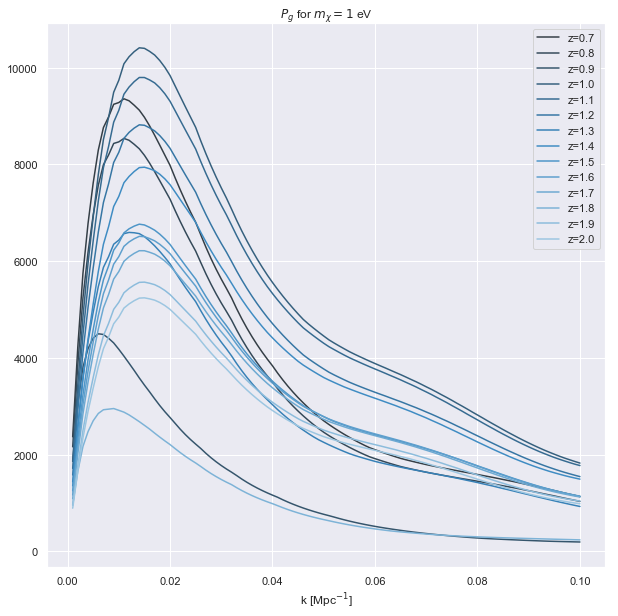

In [15]:
sns.set_palette("Blues_d", n_colors=len(z_table))
plt.figure(figsize=(10,10))
for idx, ps in enumerate(a1.fid): 
    plt.plot(k_table, ps.ps_table, label='z={0:.1f}'.format(z_table[idx]))
plt.title(r'$P_g$ for $m_\chi=1$ eV')
plt.xlabel(r'k [Mpc$^{-1}$]')
plt.legend()
plt.show()

### Plot derivatives of power spectra

Now, we plot $\frac{dP_g}{d\theta}$ for $z=0.7$ in each parameter... 

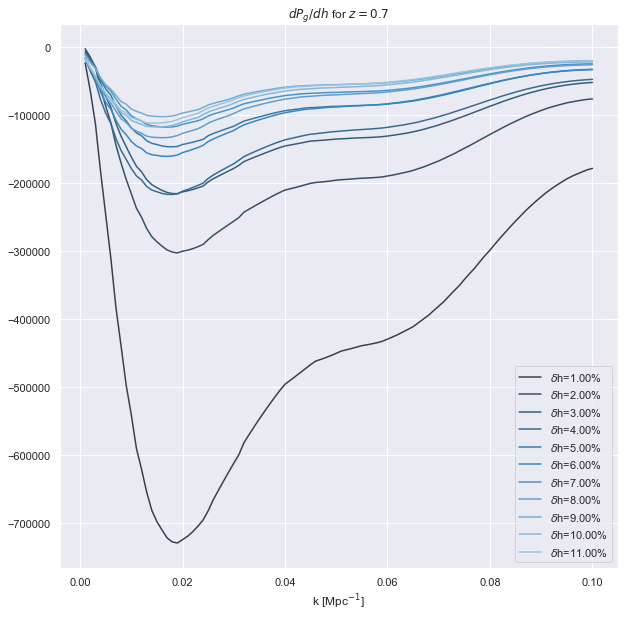

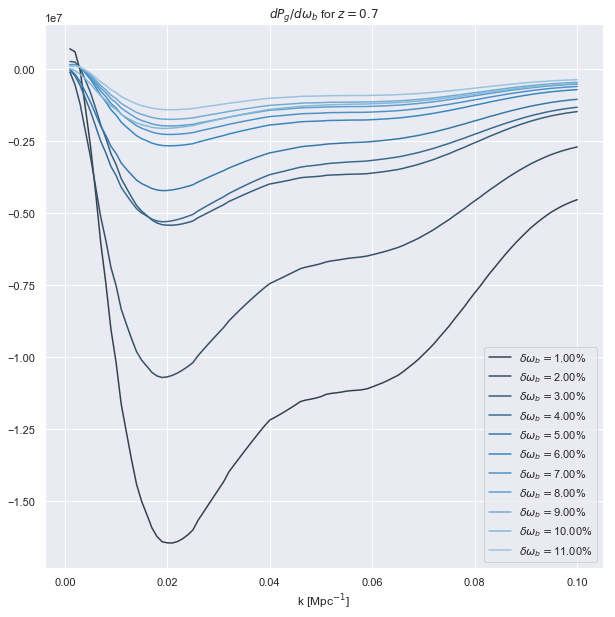

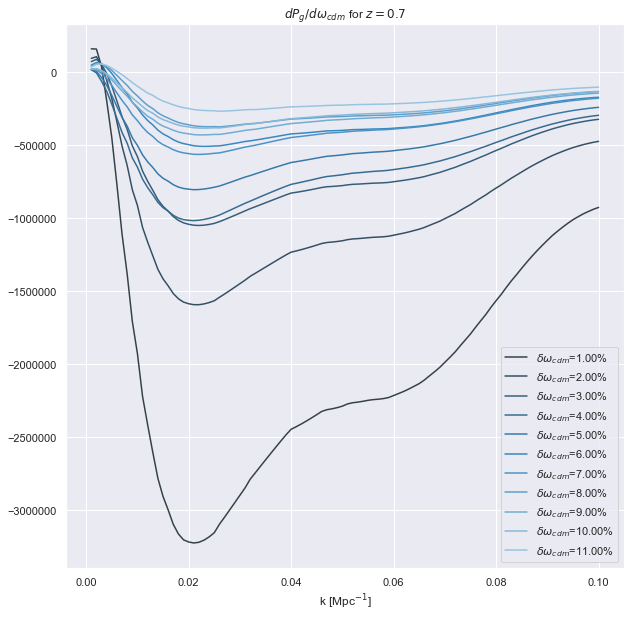

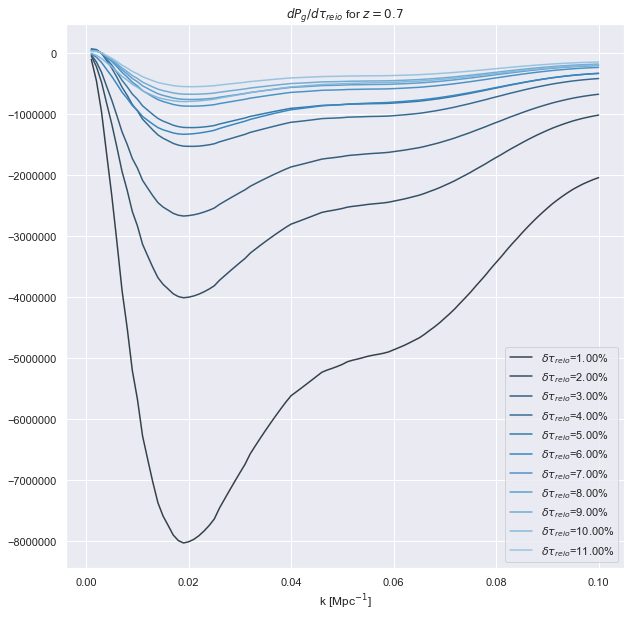

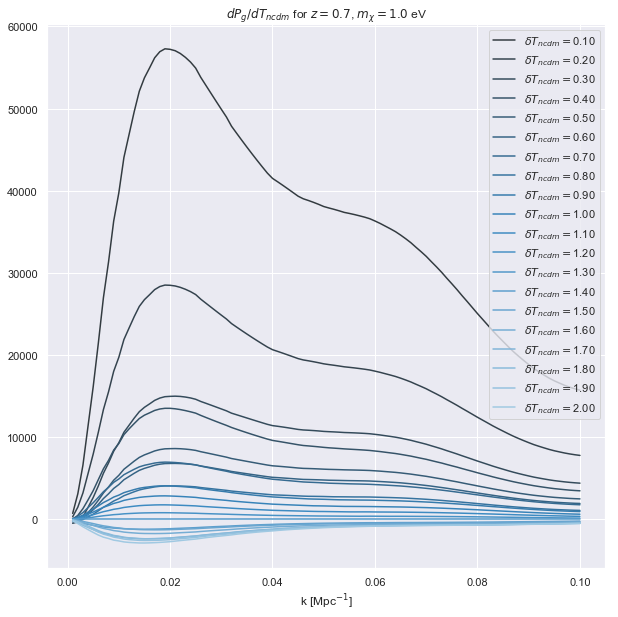

In [16]:
sns.set_palette("Blues_d", n_colors=len(relvary))
plt.figure(figsize=(10,10))
for idx, ps in enumerate(a1.h_var[0]): 
    plt.plot(k_table, ps.dps_table['h'], label=r'$\delta$'+'h={0:.2f}%'.format((relvary[idx]-1)*100.))
plt.title(r'$dP_g/dh$ for $z=0.7$')
plt.xlabel(r'k [Mpc$^{-1}$]')
plt.legend()
plt.show()

plt.figure(figsize=(10,10))
for idx, ps in enumerate(a1.omega_b_var[0]): 
    plt.plot(k_table, ps.dps_table['omega_b'], label=r'$\delta\omega_b=$'+'{0:.2f}%'.format((relvary[idx]-1)*100.))
plt.title(r'$dP_g/d\omega_b$ for $z=0.7$')
plt.xlabel(r'k [Mpc$^{-1}$]')
plt.legend()
plt.show()

plt.figure(figsize=(10,10))
for idx, ps in enumerate(a1.omega_cdm_var[0]): 
    plt.plot(k_table, ps.dps_table['omega_cdm'], label=r'$\delta\omega_{cdm}$'+'={0:.2f}%'.format((relvary[idx]-1)*100.))
plt.title(r'$dP_g/d\omega_{cdm}$ for $z=0.7$')
plt.xlabel(r'k [Mpc$^{-1}$]')
plt.legend()
plt.show()

plt.figure(figsize=(10,10))
for idx, ps in enumerate(a1.tau_reio_var[0]): 
    plt.plot(k_table, ps.dps_table['tau_reio'], label=r'$\delta\tau_{reio}$'+'={0:.2f}%'.format((relvary[idx]-1)*100.))
plt.title(r'$dP_g/d\tau_{reio}$ for $z=0.7$')
plt.xlabel(r'k [Mpc$^{-1}$]')
plt.legend()
plt.show()

sns.set_palette("Blues_d", n_colors=len(t_vary))
plt.figure(figsize=(10,10))
for idx, ps in enumerate(a1.T_ncdm_var[0]): 
    plt.plot(k_table, ps.dps_table['T_ncdm'], label=r'$\delta T_{ncdm}=$'+'{0:.2f}'.format((t_vary[idx])))
plt.title(r'$dP_g/dT_{ncdm}$ for $z=0.7$, $m_\chi=1.0$ eV')
plt.xlabel(r'k [Mpc$^{-1}$]')
plt.legend()
plt.show()

### Plot difference between power spectra derivatives

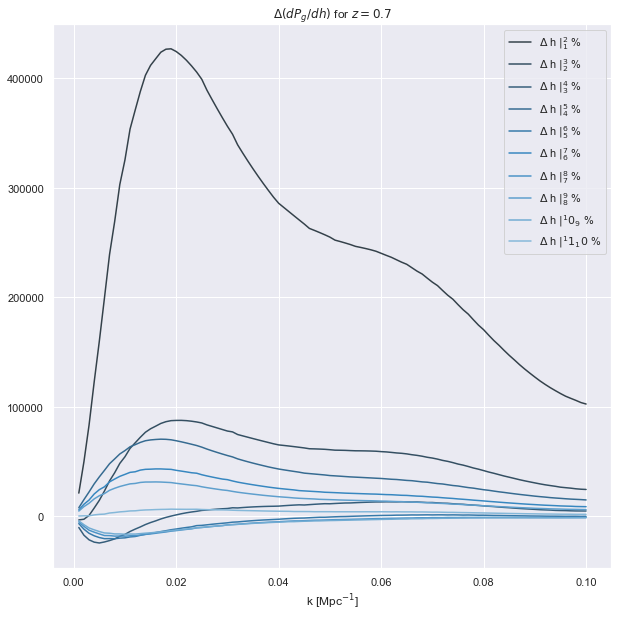

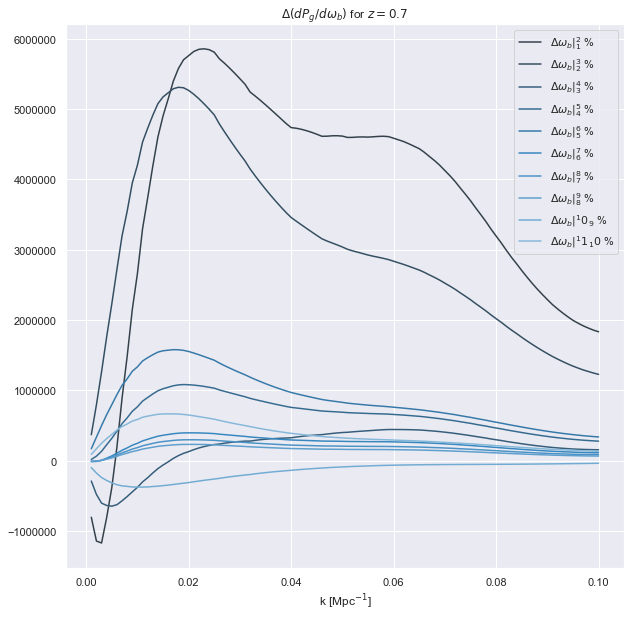

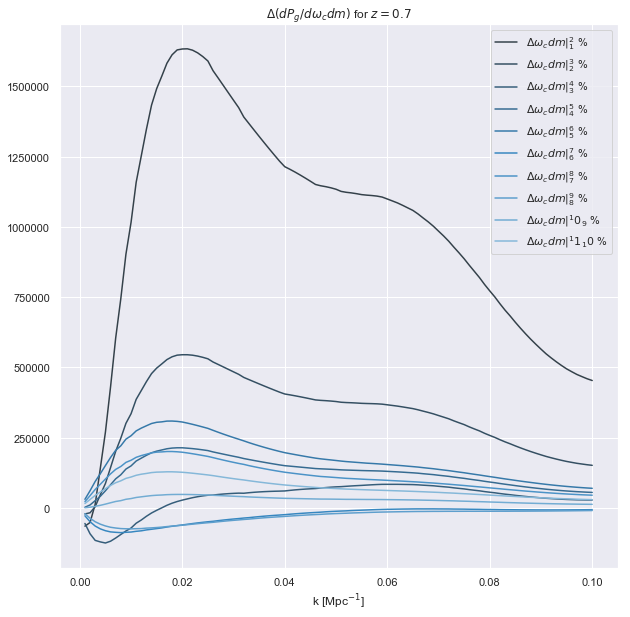

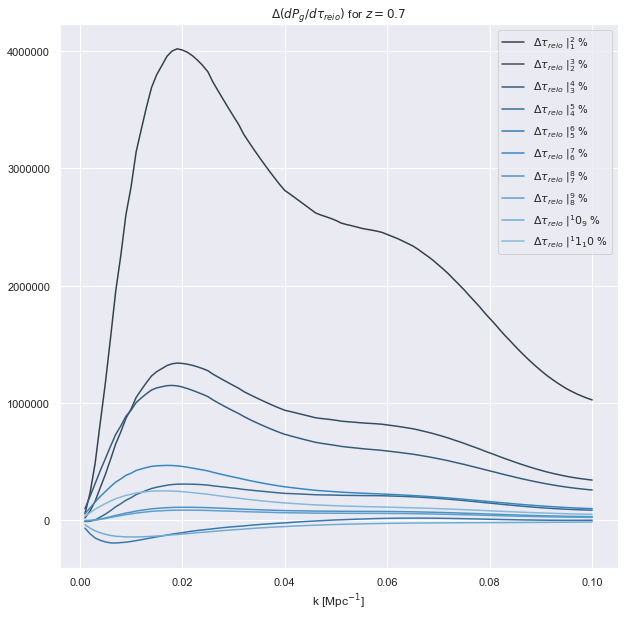

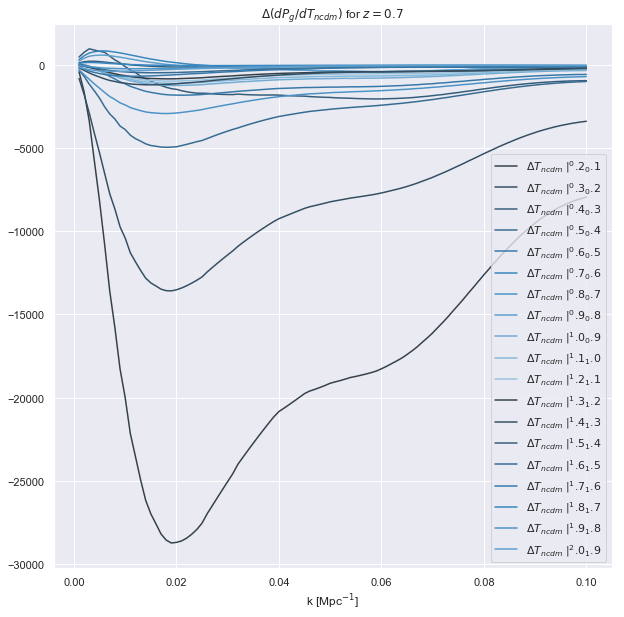

In [17]:
sns.set_palette("Blues_d", n_colors=len(relvary))
plt.figure(figsize=(10,10))
for i in range(len(a1.h_var[0])-1): 
    plt.plot(k_table, a1.h_var[0][i+1].dps_table['h'] - a1.h_var[0][i].dps_table['h'], 
             label=r'$\Delta$ h $|^{:.0f}_{:.0f}$ %'.format((relvary[i+1]-1)*100., (relvary[i]-1)*100.))
plt.title(r'$\Delta(dP_g/dh)$ for $z=0.7$')
plt.xlabel(r'k [Mpc$^{-1}$]')
plt.legend()
plt.show()

sns.set_palette("Blues_d", n_colors=len(relvary))
plt.figure(figsize=(10,10))
for i in range(len(a1.omega_b_var[0])-1): 
    plt.plot(k_table, a1.omega_b_var[0][i+1].dps_table['omega_b'] - a1.omega_b_var[0][i].dps_table['omega_b'], 
             label=r'$\Delta \omega_b |^{:.0f}_{:.0f}$ %'.format((relvary[i+1]-1)*100., (relvary[i]-1)*100.))
plt.title(r'$\Delta(dP_g/d\omega_b)$ for $z=0.7$')
plt.xlabel(r'k [Mpc$^{-1}$]')
plt.legend()
plt.show()

sns.set_palette("Blues_d", n_colors=len(relvary))
plt.figure(figsize=(10,10))
for i in range(len(a1.omega_cdm_var[0])-1): 
    plt.plot(k_table, a1.omega_cdm_var[0][i+1].dps_table['omega_cdm'] - a1.omega_cdm_var[0][i].dps_table['omega_cdm'], 
             label=r'$\Delta \omega_cdm |^{:.0f}_{:.0f}$ %'.format((relvary[i+1]-1)*100., (relvary[i]-1)*100.))
plt.title(r'$\Delta(dP_g/d\omega_cdm)$ for $z=0.7$')
plt.xlabel(r'k [Mpc$^{-1}$]')
plt.legend()
plt.show()

sns.set_palette("Blues_d", n_colors=len(relvary))
plt.figure(figsize=(10,10))
for i in range(len(a1.tau_reio_var[0])-1): 
    plt.plot(k_table, a1.tau_reio_var[0][i+1].dps_table['tau_reio'] - a1.tau_reio_var[0][i].dps_table['tau_reio'], 
             label=r'$\Delta \tau_{reio}$'+' $|^{:.0f}_{:.0f}$ %'.format((relvary[i+1]-1)*100., (relvary[i]-1)*100.))
plt.title(r'$\Delta(dP_g/d\tau_{reio})$ for $z=0.7$')
plt.xlabel(r'k [Mpc$^{-1}$]')
plt.legend()
plt.show()

sns.set_palette("Blues_d", n_colors=len(relvary))
plt.figure(figsize=(10,10))
for i in range(len(a1.T_ncdm_var[0])-1): 
    plt.plot(k_table, a1.T_ncdm_var[0][i+1].dps_table['T_ncdm'] - a1.T_ncdm_var[0][i].dps_table['T_ncdm'], 
             label=r'$\Delta T_{ncdm}$'+' $|^{:.1f}_{:.1f}$'.format(t_vary[i+1], t_vary[i]))
plt.title(r'$\Delta(dP_g/dT_{ncdm})$ for $z=0.7$')
plt.xlabel(r'k [Mpc$^{-1}$]')
plt.legend()
plt.show()

In [22]:
a1.fid[10].ps_table

array([1089.42204866, 2019.6860159 , 2841.71320106, 3503.95539253,
       4073.2608073 , 4595.94709025, 5033.20099012, 5309.34847284,
       5629.06961394, 5784.46649847, 5995.71429017, 6089.75465539,
       6160.40889835, 6215.3192743 , 6214.88883101, 6183.5800845 ,
       6144.11375927, 6080.783418  , 6000.60210834, 5903.43391354,
       5778.15922383, 5651.89260422, 5526.10928303, 5401.85719008,
       5277.09296585, 5112.09486195, 4956.45088663, 4809.45119029,
       4670.44613995, 4538.84211026, 4414.09704746, 4279.03133996,
       4141.70697852, 4012.78939112, 3891.53356763, 3777.27976326,
       3669.44166064, 3567.4964484 , 3470.97646428, 3381.9321321 ,
       3297.54306883, 3217.199478  , 3140.61873432, 3067.54387377,
       2997.74075023, 2932.60450399, 2879.3710085 , 2827.94666467,
       2778.24529926, 2730.18574327, 2685.85398379, 2648.09337854,
       2611.23683686, 2575.26127109, 2541.26616001, 2510.35198795,
       2480.02838137, 2450.28836833, 2421.32489852, 2392.96558

In [23]:
a1.T_ncdm_var[0][0].ps_table

array([ 2445.01196642,  4542.11443099,  6405.11045786,  7920.24398444,
        9230.01441309, 10438.13685102, 11460.55227909, 12114.19819199,
       12871.11927903, 13249.65341161, 13760.57042474, 13996.72245615,
       14182.28599909, 14330.21796242, 14346.48268503, 14290.94682038,
       14217.93405665, 14086.58426497, 13913.66854062, 13699.53560183,
       13422.66584396, 13141.33106968, 12859.31084632, 12579.32813512,
       12295.58963691, 11922.71700616, 11570.02174151, 11236.09375976,
       10919.62136065, 10619.38956258, 10334.27615027, 10026.33863079,
        9715.34971886,  9422.78682277,  9147.06750507,  8886.78504592,
        8640.68474696,  8407.64396545,  8186.74120189,  7986.03823402,
        7794.77353339,  7612.3013014 ,  7438.03307245,  7271.43151307,
        7112.00500626,  6973.01467994,  6850.97867709,  6732.88155348,
        6618.55015499,  6507.82001354,  6415.04030245,  6327.23283752,
        6241.41713225,  6157.55092494,  6083.39299526,  6010.75063807,
      